In [280]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, cross_val_score

In [281]:
%matplotlib inline
import matplotlib.pyplot as plt

In [282]:
def count_relative_accuracy(predicted,actual):
    EPS = 300 # 1% value of error
    succes_counter = 0
    whole_size = len(actual)
    for i in range(len(actual)):
        if np.abs(predicted[i] - actual[i]) < EPS:
            succes_counter += 1
    return str(float(succes_counter)/whole_size*100)+'%'

In [283]:
def combine(a,b): # b is for residential
    result = []
    for i in range(len(a)):
        result.append(a[i]+198.*np.sign(b[i])/(1.-1./np.log(np.abs(b[i])))) # 2504
    return np.array(result)

In [284]:
ekb_data = pd.read_excel('Ekaterinburg.xlsx', sheetname='TRANSACTIONS', converters={'TIME' : lambda x: str(x)})

In [285]:
# Biggest
atm_64 = ekb_data[ekb_data['TERM'] == 1140064]

# Strangest
atm_39 = ekb_data[ekb_data['TERM'] == 1140039]
atm_14 = ekb_data[ekb_data['TERM'] == 1120014]

# Common
atm_01 = ekb_data[ekb_data['TERM'] == 1290001]
atm_43 = ekb_data[ekb_data['TERM'] == 1140043]

In [286]:
def make_time_series(atm):
    years = atm['OPERDATE'].map(lambda x: str(x)[:4])
    month = atm['OPERDATE'].map(lambda x: str(x)[4:6])
    days = atm['OPERDATE'].map(lambda x: str(x)[6:8])
    hours = atm['TIME'].map(lambda x: str(x)[:2])
    minutes = atm['TIME'].map(lambda x: str(x)[2:4])

    years.index = range(len(years))
    month.index = range(len(years))
    days.index = range(len(years))
    hours.index = range(len(years))
    minutes.index = range(len(years))

    dates = []
    for i in range(len(years)):
        dates.append(str(years[i]) + str('-') + str(month[i]) + str(' ') + str(days[i]) + str(' ') + str(hours[i]) + str(':') + str(minutes[i]))

    dates = pd.Series(dates)
    dates = pd.to_datetime(dates)

    resulting_series = atm['VALUE']#.cumsum()
    resulting_series.index = pd.DatetimeIndex(dates)
    
    split_point = int(0.7*len(resulting_series))
    series_train = resulting_series.iloc[:split_point]
    series_test = resulting_series.iloc[split_point:]
    
    return [series_train,series_test]

atm_64_train,atm_64_test = make_time_series(atm_01)

In [287]:
sarimax_m = sm.tsa.statespace.SARIMAX(atm_64_train, trend='c', order=(3,3,1))
sarimax_m = sarimax_m.fit(disp=False)

In [288]:
sarimax_pred = np.array(list(sarimax_m.predict(exog=atm_64_test.index[:,None].flatten()[:,None])))+list(atm_64_train.values)[-1]

In [289]:
print len(atm_64_test)

5220


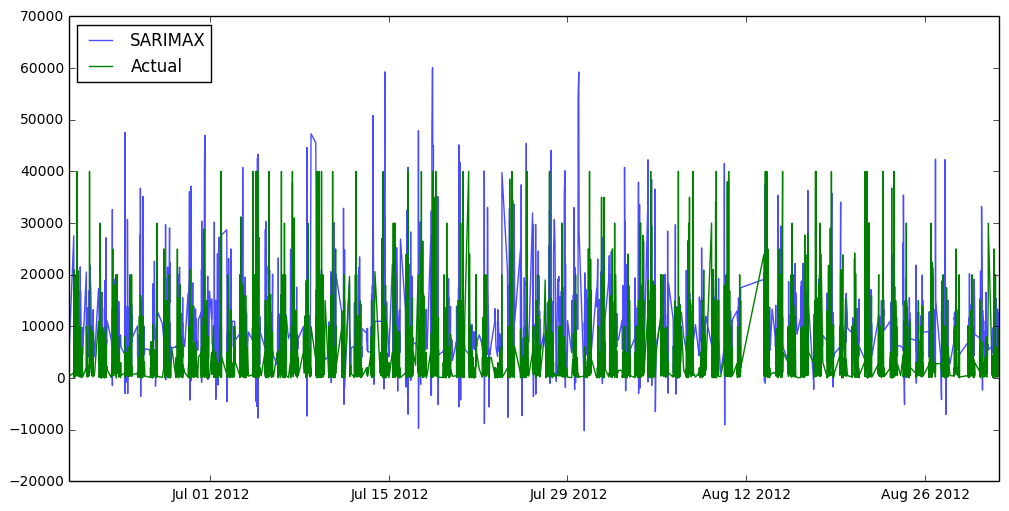

In [290]:
fig3 = plt.figure(figsize=(12,6))

c111 = fig3.add_subplot(111)
c111.plot(list(atm_64_test.index), sarimax_pred[:len(atm_64_test)], color='blue', label='SARIMAX', alpha=0.7)
c111.plot(list(atm_64_test.index), atm_64_test.values, color='green', label='Actual')
c111.legend(loc='upper left')

plt.show()

In [291]:
print count_relative_accuracy(sarimax_pred,atm_64_test.values)

1.72413793103%


In [292]:
decomposed_series = sm.tsa.seasonal_decompose(atm_64_train, freq=1)
decomposed_series.resid.fillna(value=0, inplace=True) # Not working

In [293]:
from sklearn.ensemble import RandomForestRegressor
import time

In [294]:
RF_model = RandomForestRegressor(n_estimators=39, random_state=42) # with optimal tree amount

In [295]:
train_indexes_64 = pd.Series(atm_64_train.index)
train_indexes_64 = np.array(train_indexes_64.map(lambda x: time.mktime(x.to_pydatetime().timetuple())))[:,None]

test_indexes_64 = pd.Series(atm_64_test.index)
test_indexes_64 = np.array(test_indexes_64.map(lambda x: time.mktime(x.to_pydatetime().timetuple())))[:,None]

In [296]:
RF_model.fit(train_indexes_64, atm_64_train.values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=39, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [297]:
RF39_prediction_coef = RF_model.predict(test_indexes_64)

In [298]:
RF39_prediction = RF39_prediction_coef+0.35*np.sign(sarimax_pred[:len(RF39_prediction_coef)])*np.abs(sarimax_pred[:len(RF39_prediction_coef)])

In [299]:
#print RF39_prediction
RF39_prediction = map(lambda x: 0 if x < 0 else x, list(RF39_prediction))

In [300]:
combined_prediction = combine(RF39_prediction,sarimax_pred)*1

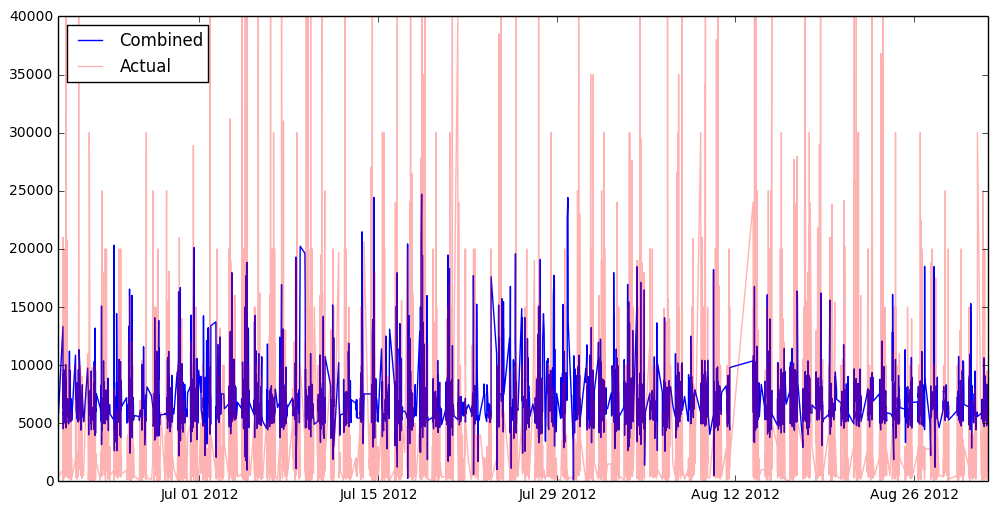

In [301]:
fig4 = plt.figure(figsize=(12,6))

d111 = fig4.add_subplot(111)
d111.plot(list(atm_64_test.index), RF39_prediction[:len(RF39_prediction_coef)], color='blue', label='Combined')
d111.plot(list(atm_64_test.index), atm_64_test.values, color='red', label='Actual', alpha=0.3)
d111.legend(loc='upper left')

plt.show()

In [302]:
print count_relative_accuracy(combined_prediction,atm_64_test.values)

2.04980842912%
